In [ ]:
#Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import the dataset
import pandas as pd

df = pd.read_csv('drive/MyDrive/Mestrado UFF/Inteligência Artificial/Trabalho_3_ML/pokedex_(Update_05.20).csv')
#Dataset available at: https://www.kaggle.com/mariotormo/complete-pokemon-dataset-updated-090420?select=pokedex_%28Update_05.20%29.csv

#Remove columns with names and non-important data
df.drop(["Unnamed: 0", "name", "german_name", "japanese_name", "species", "type_number", "ability_1", "ability_2", "ability_hidden", "egg_type_number", "egg_type_1", "egg_type_2"], axis=1, inplace=True)

#Remove rows with Nan in the type_1 and/or growth_rate categories
df.dropna(subset=['type_1', 'growth_rate'], inplace=True)
#Fill Nans with 0
df.fillna(0, inplace=True)
#df.head()

In [ ]:
#Preprocess the data and chage strings into categorical data
from sklearn.preprocessing import OrdinalEncoder

df[['status', 'growth_rate']] = OrdinalEncoder().fit_transform(df[['status', 'growth_rate']])

type_2_list = list(set(df.type_2.tolist()))
df.type_2.replace(type_2_list, range(len(type_2_list)), inplace=True)

#Separate if a pokemon is of one of the basic types (Grass, Fire, Water) or not
type_1_list = list(set(df.type_1.tolist()))
for item in type_1_list:
  if (item=='Grass') or (item=='Fire') or (item=='Water'):
    df.type_1.replace(item, 0, inplace=True)
  else:
    df.type_1.replace(item, 1, inplace=True)

#df.head()

In [ ]:
#Divide the dataset in two sets: one for training and one for testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['type_1'], axis=1), df['type_1'], test_size=0.3, random_state=42)
#y_train and y_test have the 'type_1' column

In [ ]:
#Import the necessary libraries
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier


#Create the pipelines
linearsvc42_pipeline = make_pipeline(LinearSVC(random_state=42))
linearsvc0_pipeline = make_pipeline(LinearSVC(random_state=0))
decision42_pipeline = make_pipeline(DecisionTreeClassifier(random_state=42))
decision0_pipeline = make_pipeline(DecisionTreeClassifier(random_state=0))
logistic42_pipeline = make_pipeline(LogisticRegression(random_state=42))
logistic0_pipeline = make_pipeline(LogisticRegression(random_state=0))
knClass5_pipeline = make_pipeline(KNeighborsClassifier(n_neighbors=5))
knClass4_pipeline = make_pipeline(KNeighborsClassifier(n_neighbors=4))
perceptron_pipeline = make_pipeline(Perceptron())
randomFor_pipeline = make_pipeline(RandomForestClassifier())


estimators = [('LinearSVC 42', linearsvc42_pipeline),
              ('LinearSVC 0', linearsvc0_pipeline),
              ('Decision Tree 42', decision42_pipeline),
              ('Decision Tree 0', decision0_pipeline),
              ('Logistic Regression 42', logistic42_pipeline),
              ('Logistic Regression 0', logistic0_pipeline),
              ('K Neighbours 5', knClass5_pipeline),
              ('K Neighbours 4', knClass4_pipeline),
              ('Perceptron', perceptron_pipeline),
              ('Random Forest', randomFor_pipeline)
              ]

#Stack the regressors using an ensemble method
stacking_classifier = StackingClassifier(estimators=estimators)

In [ ]:
from sklearn.model_selection import cross_validate, cross_val_predict
import sklearn.metrics as metrics

scoring = ['accuracy', 'precision', 'recall', 'f1']
scores = []
y_pred_total = []
fpr = []
tpr = []
auc = []

for (name, est) in (estimators + [('Stacking Classifier',stacking_classifier)]):
    score = cross_validate(est, X_test, y_test, scoring=scoring, n_jobs=-1, verbose=0)
    y_pred = cross_val_predict(est, X_test, y_test, n_jobs=-1, verbose=0)
    scores.append(score)
    y_pred_total.append(y_pred)
    fpr_aux, tpr_aux, _ = metrics.roc_curve(y_test, y_pred)
    auc_aux = metrics.roc_auc_score(y_test, y_pred)
    fpr.append(fpr_aux)
    tpr.append(tpr_aux)
    auc.append(auc_aux)

#print(scores)

In [ ]:
acc_sc = []
prec_sc = []
rec_sc = []
f1_sc = []
estimators_scores = []

for item in scores:
  aux_list = []
  acc_aux = item['test_accuracy'].mean()
  prec_aux = item['test_precision'].mean()
  rec_aux = item['test_recall'].mean()
  f1_aux = item['test_f1'].mean()

  acc_sc.append(acc_aux)
  prec_sc.append(prec_aux)
  rec_sc.append(rec_aux)
  f1_sc.append(f1_aux)
  aux_list.extend([acc_aux, prec_aux, rec_aux, f1_aux])
  estimators_scores.append(aux_list)

In [ ]:
#Put the metrics into a new dataset
names = ['LinearSVC 42', 'LinearSVC 0', 'Decision Tree 42', 'Decision Tree 0', 'Logistic Regression 42', 'Logistic Regression 0', 'K Neighbours 5', 'K Neighbours 4', 'Perceptron', 'Random Forest', 'Stacking Classifier']
dict_aux = {'Estimators': names, 'Accuracy': acc_sc, 'Precision': prec_sc, 'Recall': rec_sc, 'F1': f1_sc}
df_scores = pd.DataFrame(dict_aux)
df_scores

,Estimators,Accuracy,Precision,Recall,F1
0,LinearSVC 42,0.670175,0.796091,0.822222,0.723100
1,LinearSVC 0,0.718720,0.799310,0.840000,0.799384
2,Decision Tree 42,0.928662,0.936690,0.968986,0.952134
3,Decision Tree 0,0.931994,0.944648,0.964541,0.953995
4,Logistic Regression 42,0.754151,0.801854,0.884928,0.840690
5,Logistic Regression 0,0.754151,0.801854,0.884928,0.840690
6,K Neighbours 5,0.605235,0.706440,0.787536,0.744545
7,K Neighbours 4,0.537229,0.705634,0.628019,0.664024
8,Perceptron,0.589053,0.847128,0.556812,0.645481
9,Random Forest,0.932152,0.944215,0.964541,0.953958


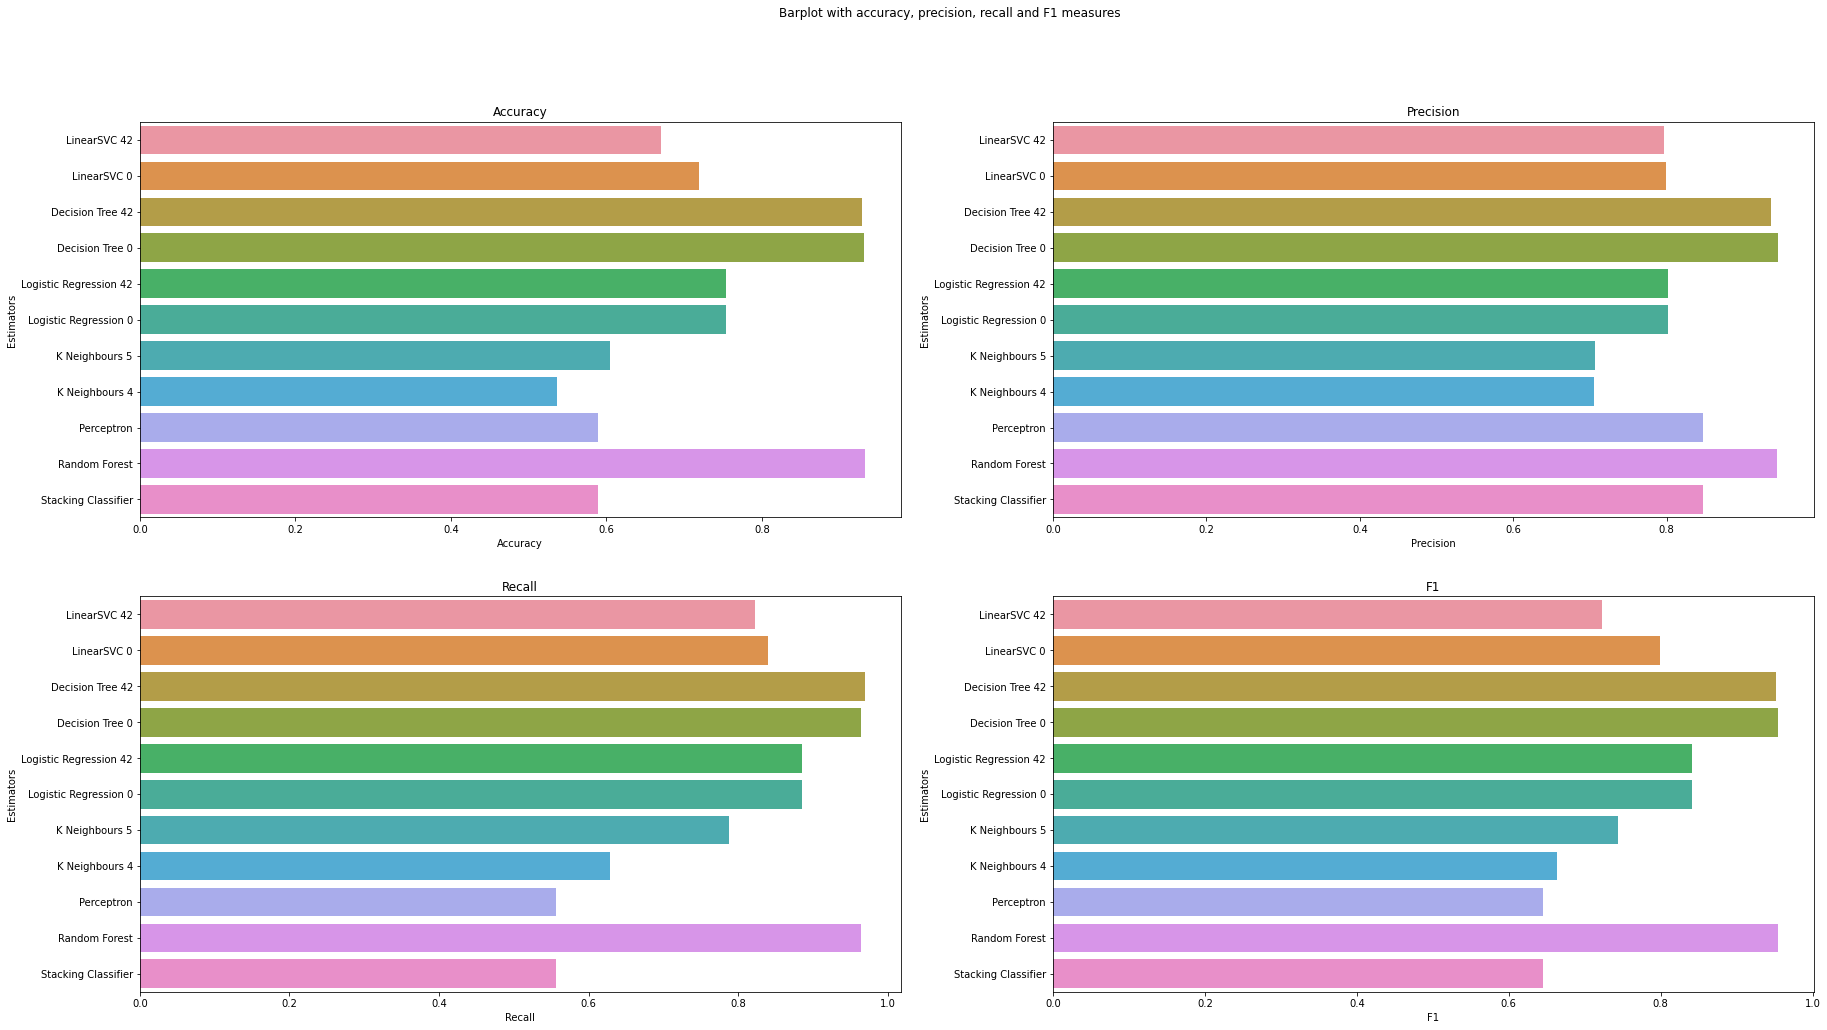

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(30, 16))

fig.suptitle('Barplot with accuracy, precision, recall and F1 measures')
axes[0, 0].set_title('Accuracy')
axes[0, 1].set_title('Precision')
axes[1, 0].set_title('Recall')
axes[1, 1].set_title('F1')

sns.barplot(ax=axes[0, 0], data=df_scores, y='Estimators', x='Accuracy', orient='h')
sns.barplot(ax=axes[0, 1], data=df_scores, y='Estimators', x='Precision', orient='h')
sns.barplot(ax=axes[1, 0], data=df_scores, y='Estimators', x='Recall', orient='h')
sns.barplot(ax=axes[1, 1], data=df_scores, y='Estimators', x='F1', orient='h')

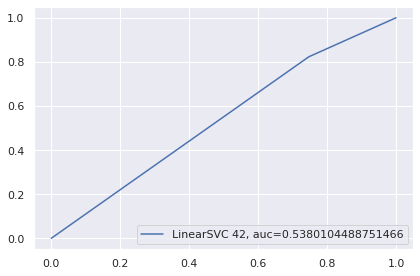

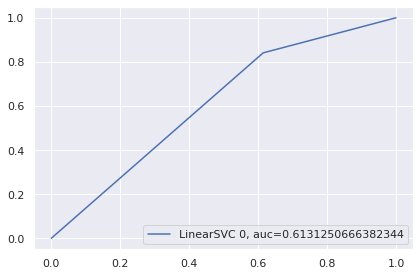

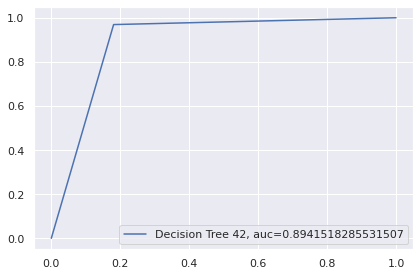

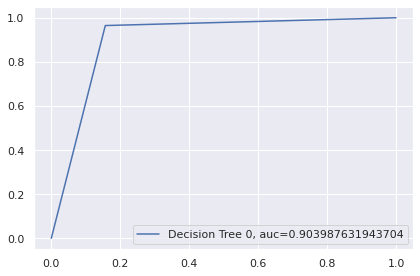

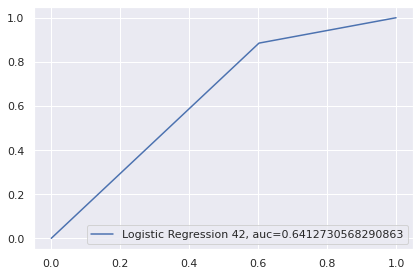

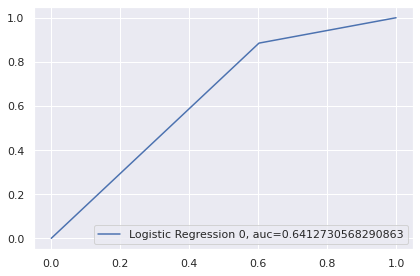

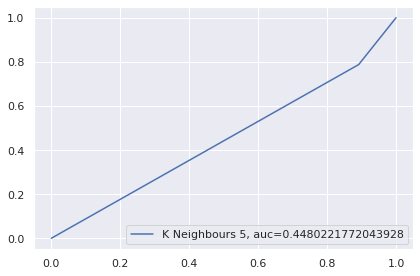

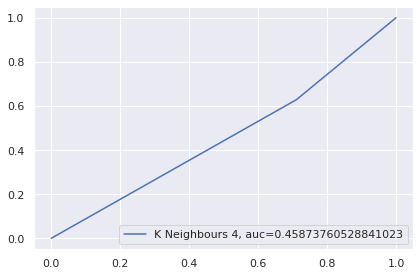

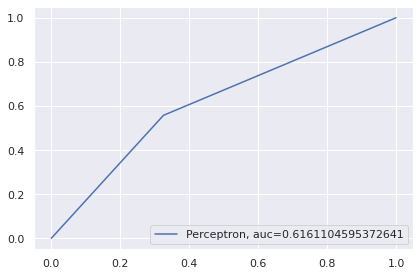

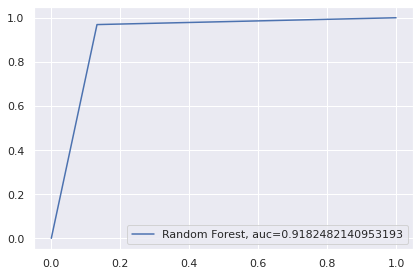

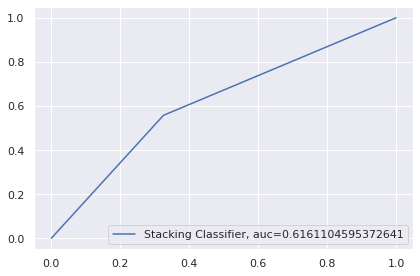

In [ ]:
#Plot the ROC curves
i=0
for item in y_pred_total:
  plt.plot(fpr[i],tpr[i],label=names[i] + ", auc="+str(auc[i]))
  plt.legend(loc=4)
  i+=1
  plt.show()

248


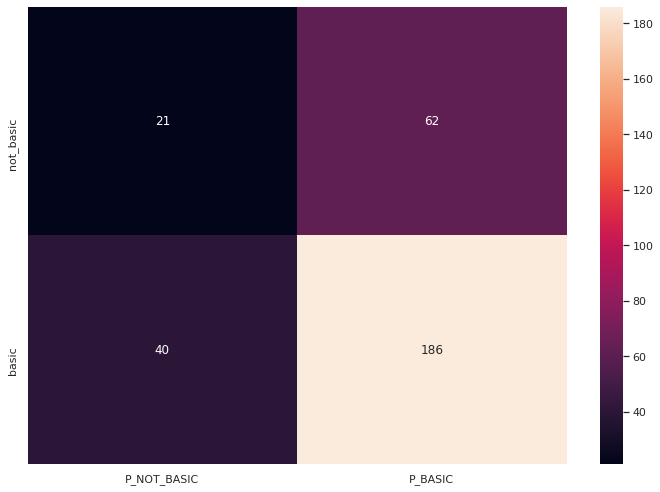

241


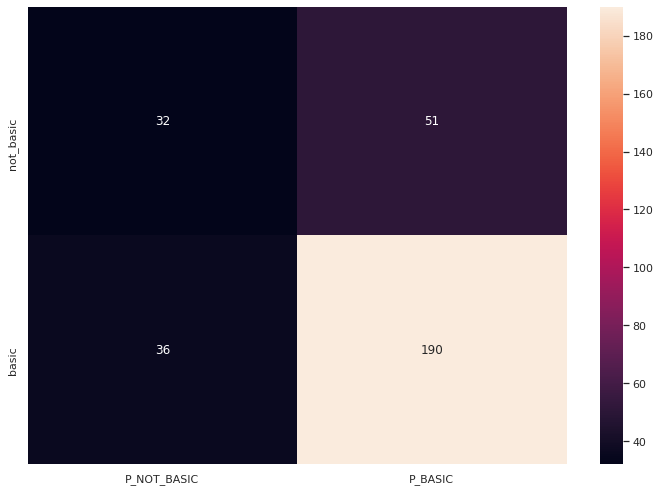

234


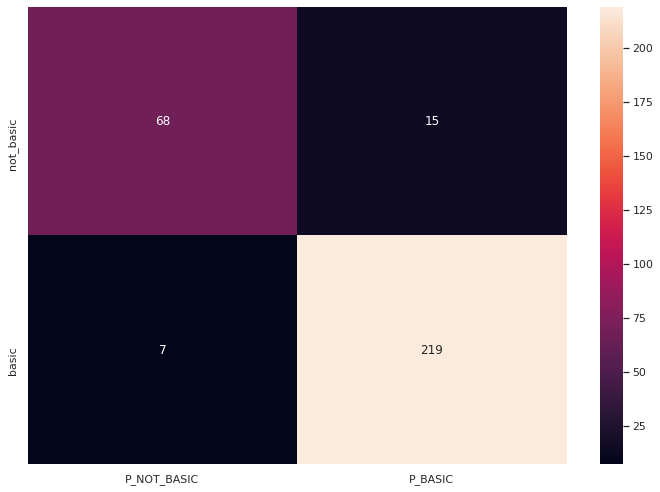

231


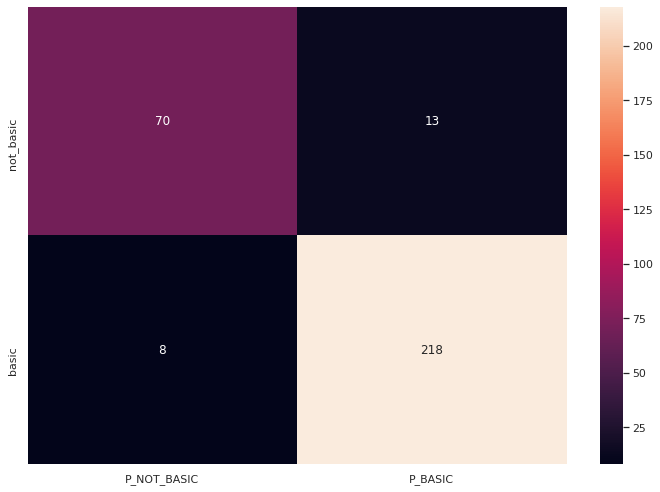

250


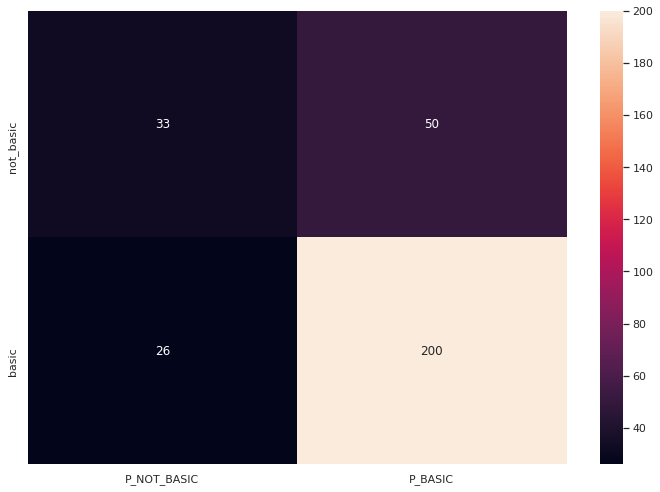

250


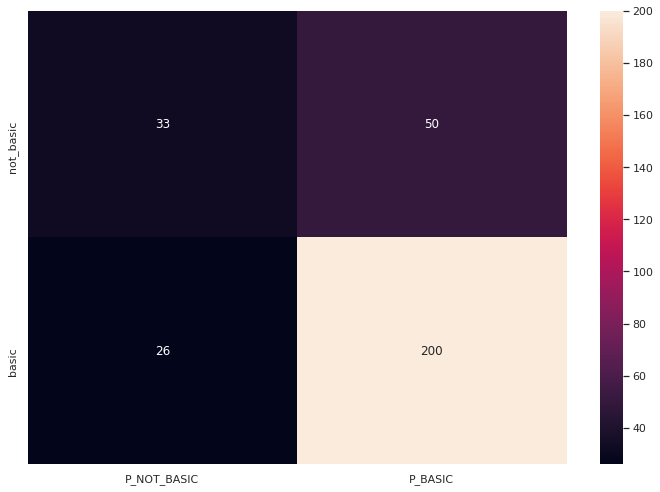

252


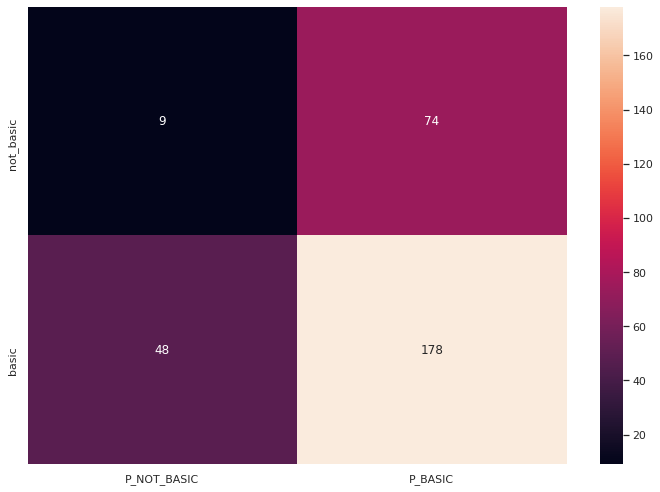

201


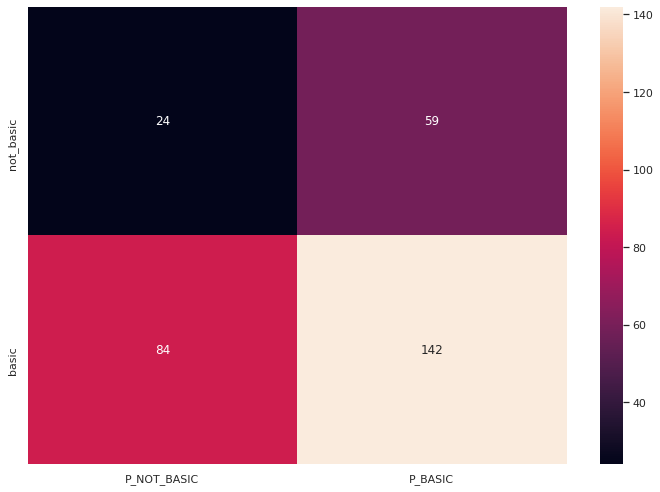

153


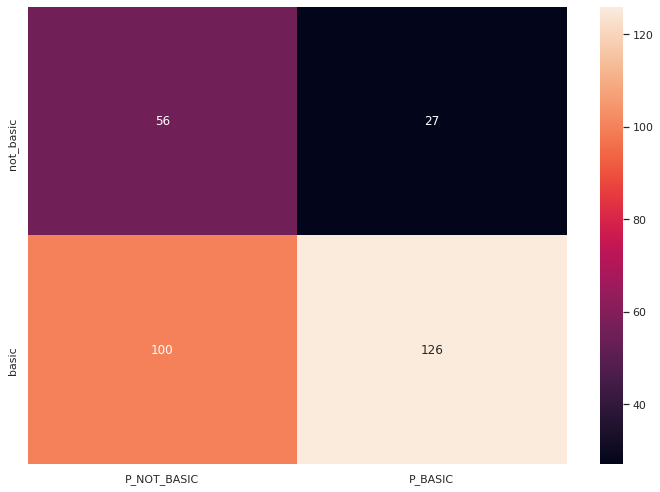

230


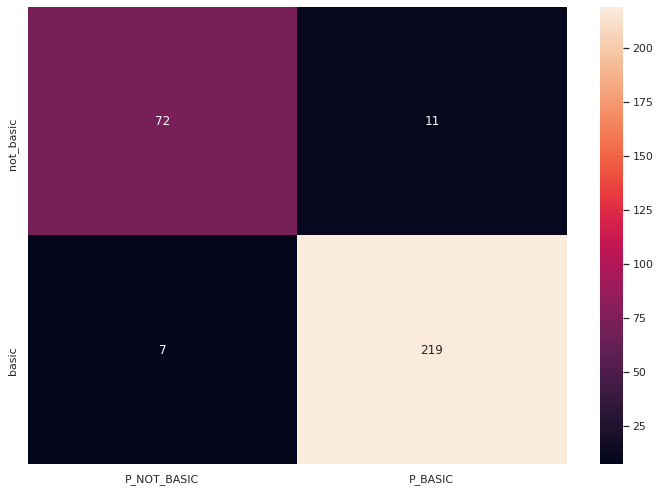

153


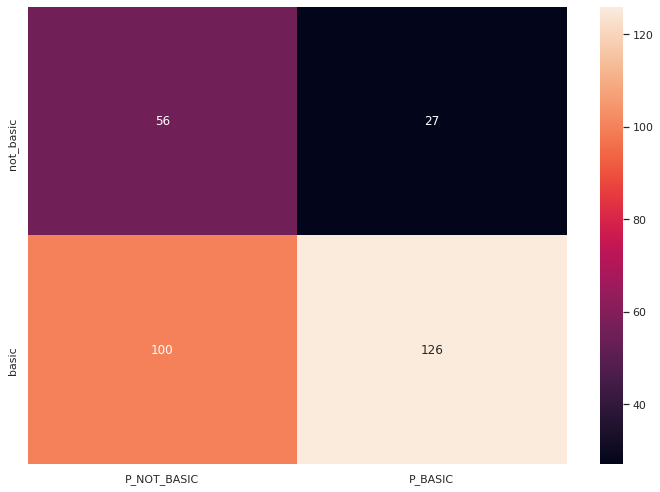

In [ ]:
#Plot the Confusion matrices

for item in y_pred_total:
  cm = metrics.confusion_matrix(y_test, item)
  print(len([x for x in item if x == 1]))
  df_cm = pd.DataFrame(cm,['not_basic','basic'], ['P_NOT_BASIC','P_BASIC'])
  plt.figure(figsize=(10,7))
  sns.set(font_scale=1)# for label size
  sns.heatmap(df_cm, annot=True,fmt='d') # font size
  plt.show()